In [17]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path 

matplotlib.rc("text", usetex=False)

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

In [18]:
def measure_runtime(func):
    def wrapper(*args, **kwargs):
        start_time = datetime.datetime.now()
        print(f"{start_time.strftime('%Y-%m-%d %H:%M:%S')}: Start of {func.__name__}")
        result = func(*args, **kwargs)
        end_time = datetime.datetime.now()
        print(f"{start_time.strftime('%Y-%m-%d %H:%M:%S')}: End of {func.__name__}, runtime of - {(end_time-start_time).total_seconds()} second(s)")
        return result
    return wrapper


def read_csv_raw_df(sample_path: Path):
    dtypes = {
        "sample_id": "object",
        "trid": "object",
        "genotype": "int64",
        "denovo_coverage": "int64",
        "allele_coverage": "int64",
        "allele_ratio": "float64",
        "child_coverage": "int64",
        "child_ratio": "float64",
        "mean_diff_father": "float64",
        "mean_diff_mother": "float64",
        "father_dropout_prob": "float64",
        "mother_dropout_prob": "float64",
        "allele_origin": "object",
        "denovo_status": "object",
        "per_allele_reads_father": "object",
        "per_allele_reads_mother": "object",
        "per_allele_reads_child": "object",
        "father_dropout": "object",
        "mother_dropout": "object",
        "child_dropout": "object",
        "index": "int64",
        "father_MC": "object",
        "mother_MC": "object",
        "child_MC": "object",
        "father_AL": "object",
        "mother_AL": "object",
        "child_AL": "object",
        "father_overlap_coverage": "object",
        "mother_overlap_coverage": "object",
    }
    print(f"Loading: {sample_path}")
    df = pd.read_csv(sample_path, delimiter='\t', dtype=dtypes)
    df.insert(0, 'sample_id', sample_path.name)
    df['min_mean_diff'] = df[['mean_diff_father', 'mean_diff_mother']].min(axis=1)
    return df

@measure_runtime
def load_sample(sample_path: Path, min_denovo_coverage: int = 0) -> pd.DataFrame:
    df_sub = read_csv_raw_df(sample_path)
    df_sub = df_sub[df_sub['denovo_coverage'] >= min_denovo_coverage]
    return df_sub

In [52]:
sample_path = Path("trgt_denovo.tsv").resolve(strict=True)

In [ ]:
df = load_sample(sample_path)

Assuming that TRGT-denovo trio was run without --quick mode, we have balanced coverage across samples, and there is no sample swap, then nearly all alleles are expected to have a de novo coverage equal to 0.

In [54]:
zero_denovo_coverage = (df['denovo_coverage'] == 0).sum() / len(df['denovo_coverage'])
zero_denovo_coverage

0.9953426426009299

Plotting the *de novo* coverage is useful for obtaining a quick overview of its distribution. In a parent-child trio, *de novo* events are expected to be extremely rare compared to the total number of sites tested. For example, if we consider testing 7 million sites and expect around 100 *de novo* events, the proportion of sites that are *de novo* would be approximately 0.00001429 of the total.

At `https://github.com/PacificBiosciences/trgt-denovo/blob/main/docs/interpretation.md` some example distributions are shown as well of expected vs problematic cases (sample swap, coverage imbalance).

Example:
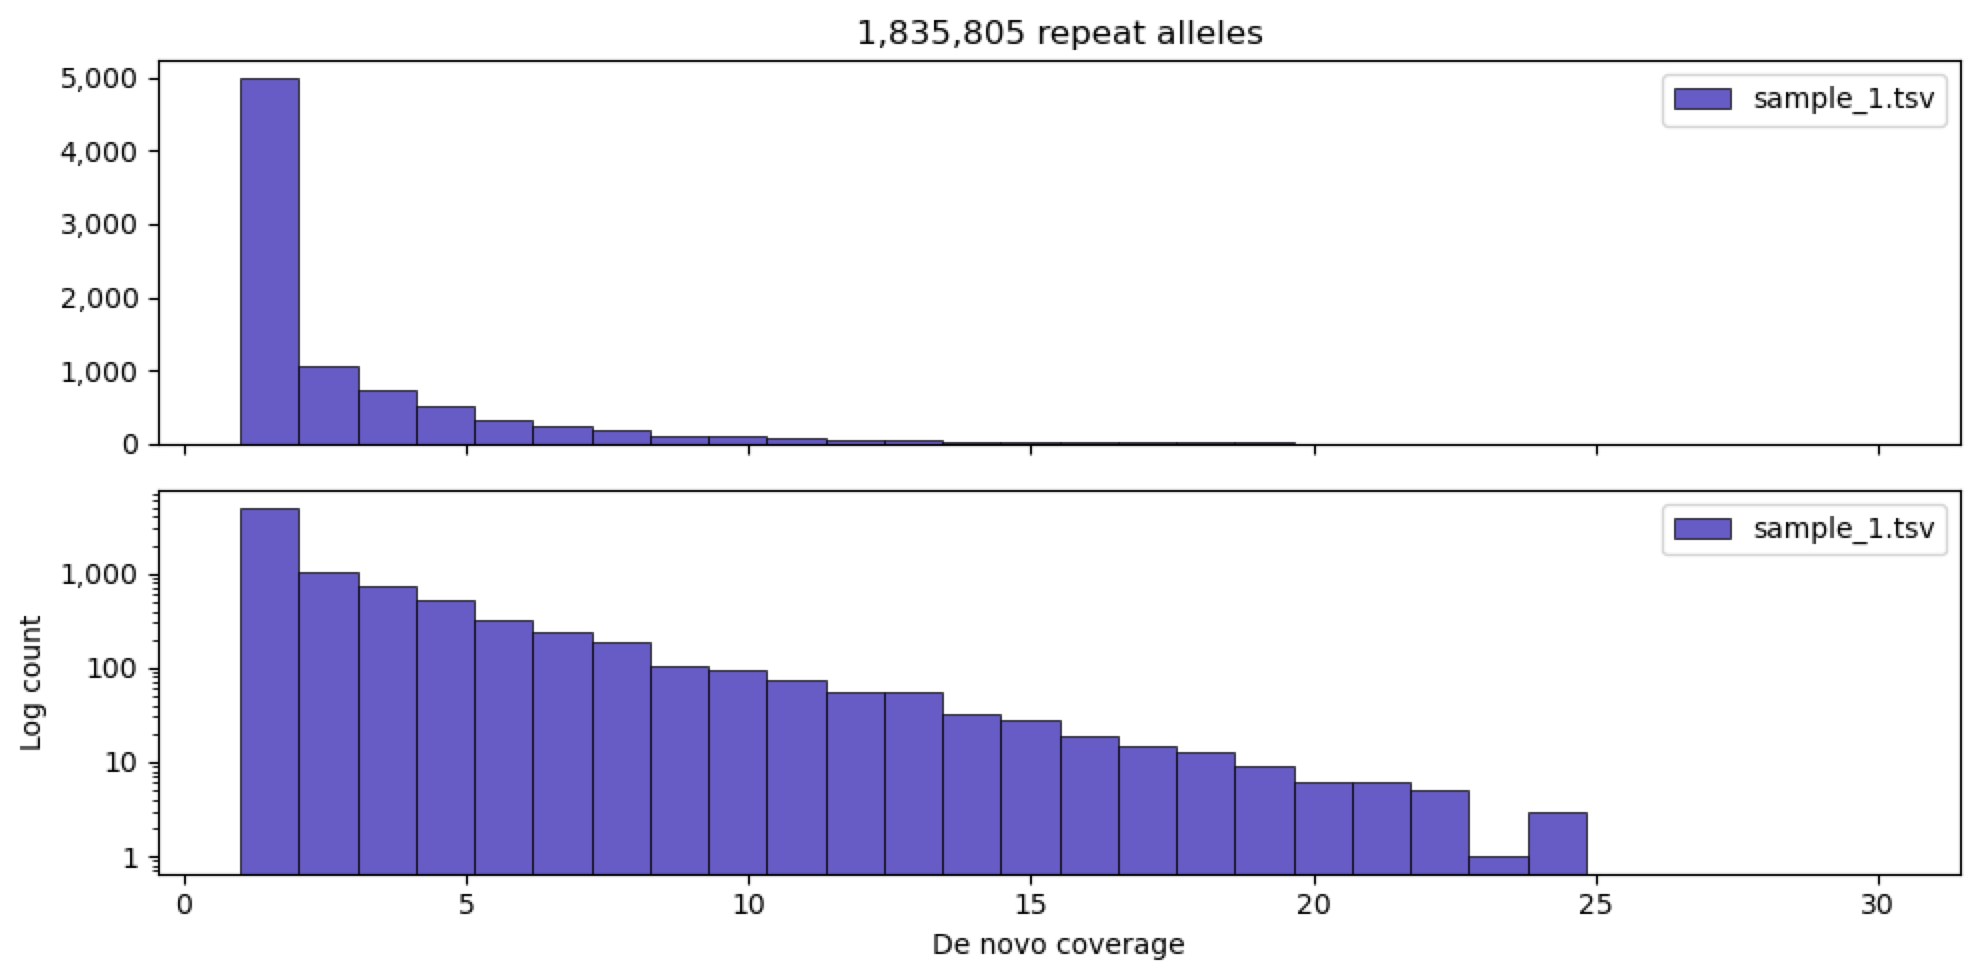

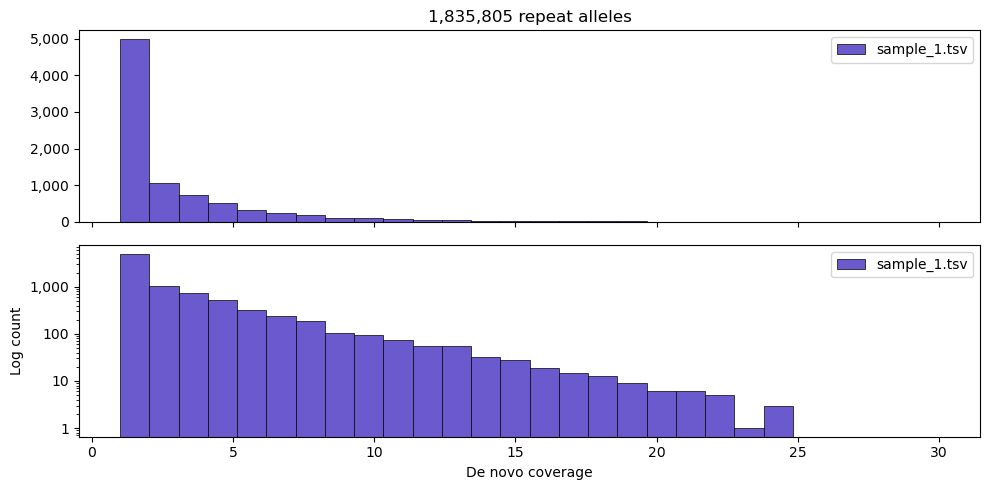

In [56]:
# This is generally a bin range that should make sense for most datasets.
# Note, that a denovo_coverage of 0 is skipped
lo_bin, hi_bin = 1, 30

params = {
    "bins": np.linspace(lo_bin, hi_bin, hi_bin - lo_bin),
    "linewidth": 0.5,
    "alpha": 1.0,
    "edgecolor": "black",
    "label": df["sample_id"].iloc[0],
    "color": "slateblue"
}

fig, axes = plt.subplots(2, 1, figsize=[10, 5], sharex=True)

axes[0].hist(df["denovo_coverage"], **params)
axes[1].hist(df["denovo_coverage"], **params)
axes[1].set_yscale("log")

for ax in axes:
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    ax.legend()

axes[0].set_title(f"{len(df):,} repeat alleles")
axes[0].set_xlabel("")
axes[1].set_xlabel("De novo coverage")
axes[1].set_ylabel("Log count")

plt.tight_layout()

TRGT-denovo is largely driven by coverage-based analysis. Hence the *de novo* coverage and its relation to the overall coverage within an allele or locus is very important to determine whether a call is likely to be a true positive *de novo* call.

Below we plot its relation to the: allele_ratio, which is the proportion of reads in an allele having de novo signal (de novo reads / all reads belonging to that allele), where this is ideally close to 1 to indicate that there is little ambiguity of there being a de novo call (lower ratios may indicate many possible causes, e.g., mosaicism, somatic instability, or stutter); child_ratio which is the proportion of reads at a locus having de novo signal (de novo reads / all reads covering a locus), which ideally approaches 0.5; min_mean_diff is the minimum mean absolute difference of both parents at a given allele, this is an approximation of the relative size of a *de novo* event. Generally you expect that most *de novo* calls are small (single motif expansions/contractions). 

Example:
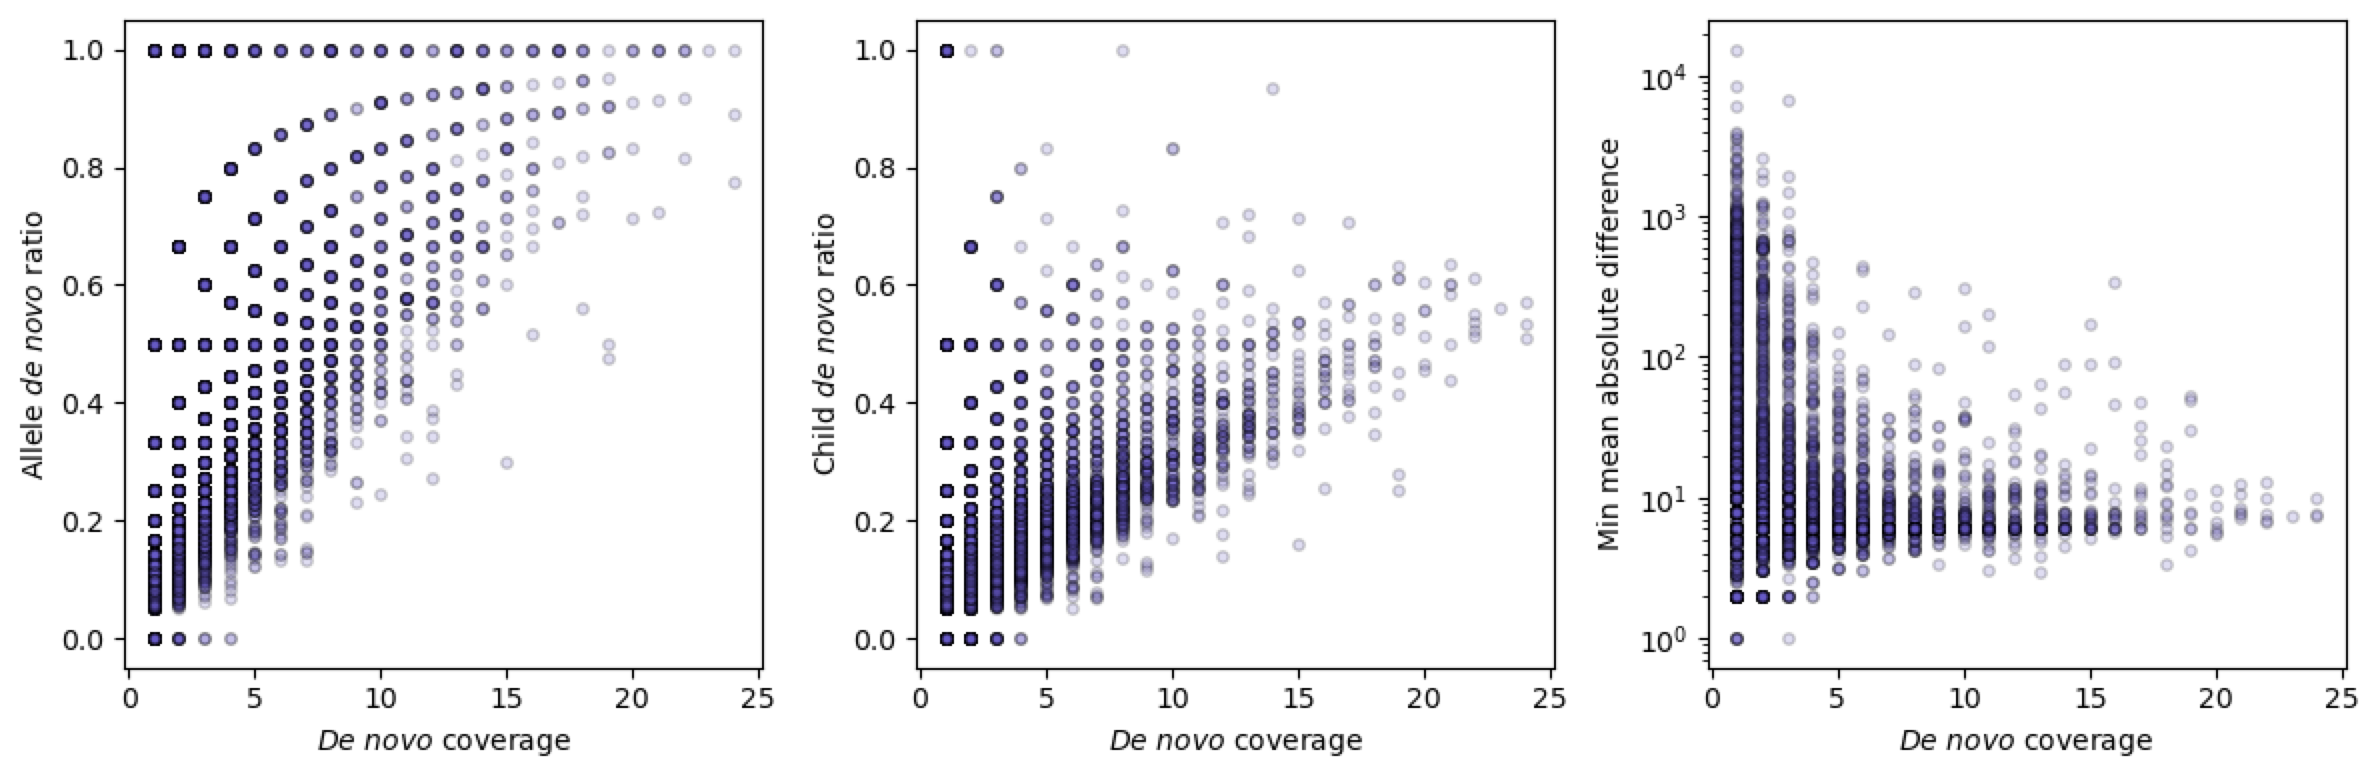

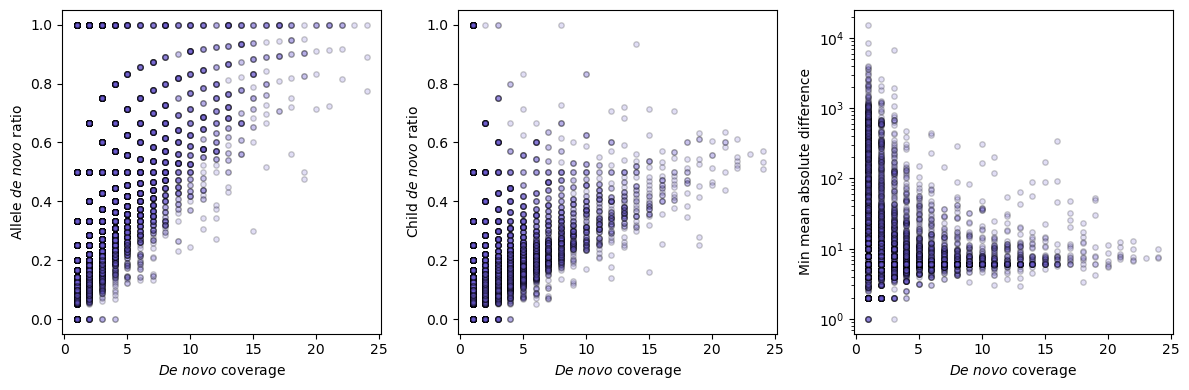

In [57]:
params = {
    "alpha": 0.2,
    "s": 15,
    "color": "slateblue",
    "edgecolor": "black",
    "zorder": 2,
}
filtered_df = df[df['denovo_coverage'] > 0]


fig, axes = plt.subplots(1, 3, figsize=[12, 4], sharey=False, sharex=True)

axes[0].scatter(filtered_df["denovo_coverage"], filtered_df["allele_ratio"],
                label=filtered_df["sample_id"].iloc[0], **params)
axes[0].set_ylabel("Allele $\it{de\ novo}$ ratio")

axes[1].scatter(filtered_df["denovo_coverage"], filtered_df["child_ratio"],
                label=filtered_df["sample_id"].iloc[0], **params)
axes[1].set_ylabel("Child $\it{de\ novo}$ ratio")

axes[2].scatter(filtered_df["denovo_coverage"], filtered_df["min_mean_diff"],
                label=filtered_df["sample_id"].iloc[0], **params)
axes[2].set_ylabel("Min mean absolute difference")
axes[2].set_yscale("log")

for ax in axes:
    ax.set_xlabel("$\it{De\ novo}$ coverage")
    ax.legend([], [], frameon=False)

plt.tight_layout()

Basic candidate selection of *de novo* candidates can be done by setting threshold on the different metrics found by TRGT-denovo. Below an example is shown.

It is very helpful to filter out tandem repeats regions that are inside segmental duplications as these are significantly harder to interpret and also much more likely to be false positives.

An example of one of the largest de novo events in this sample:
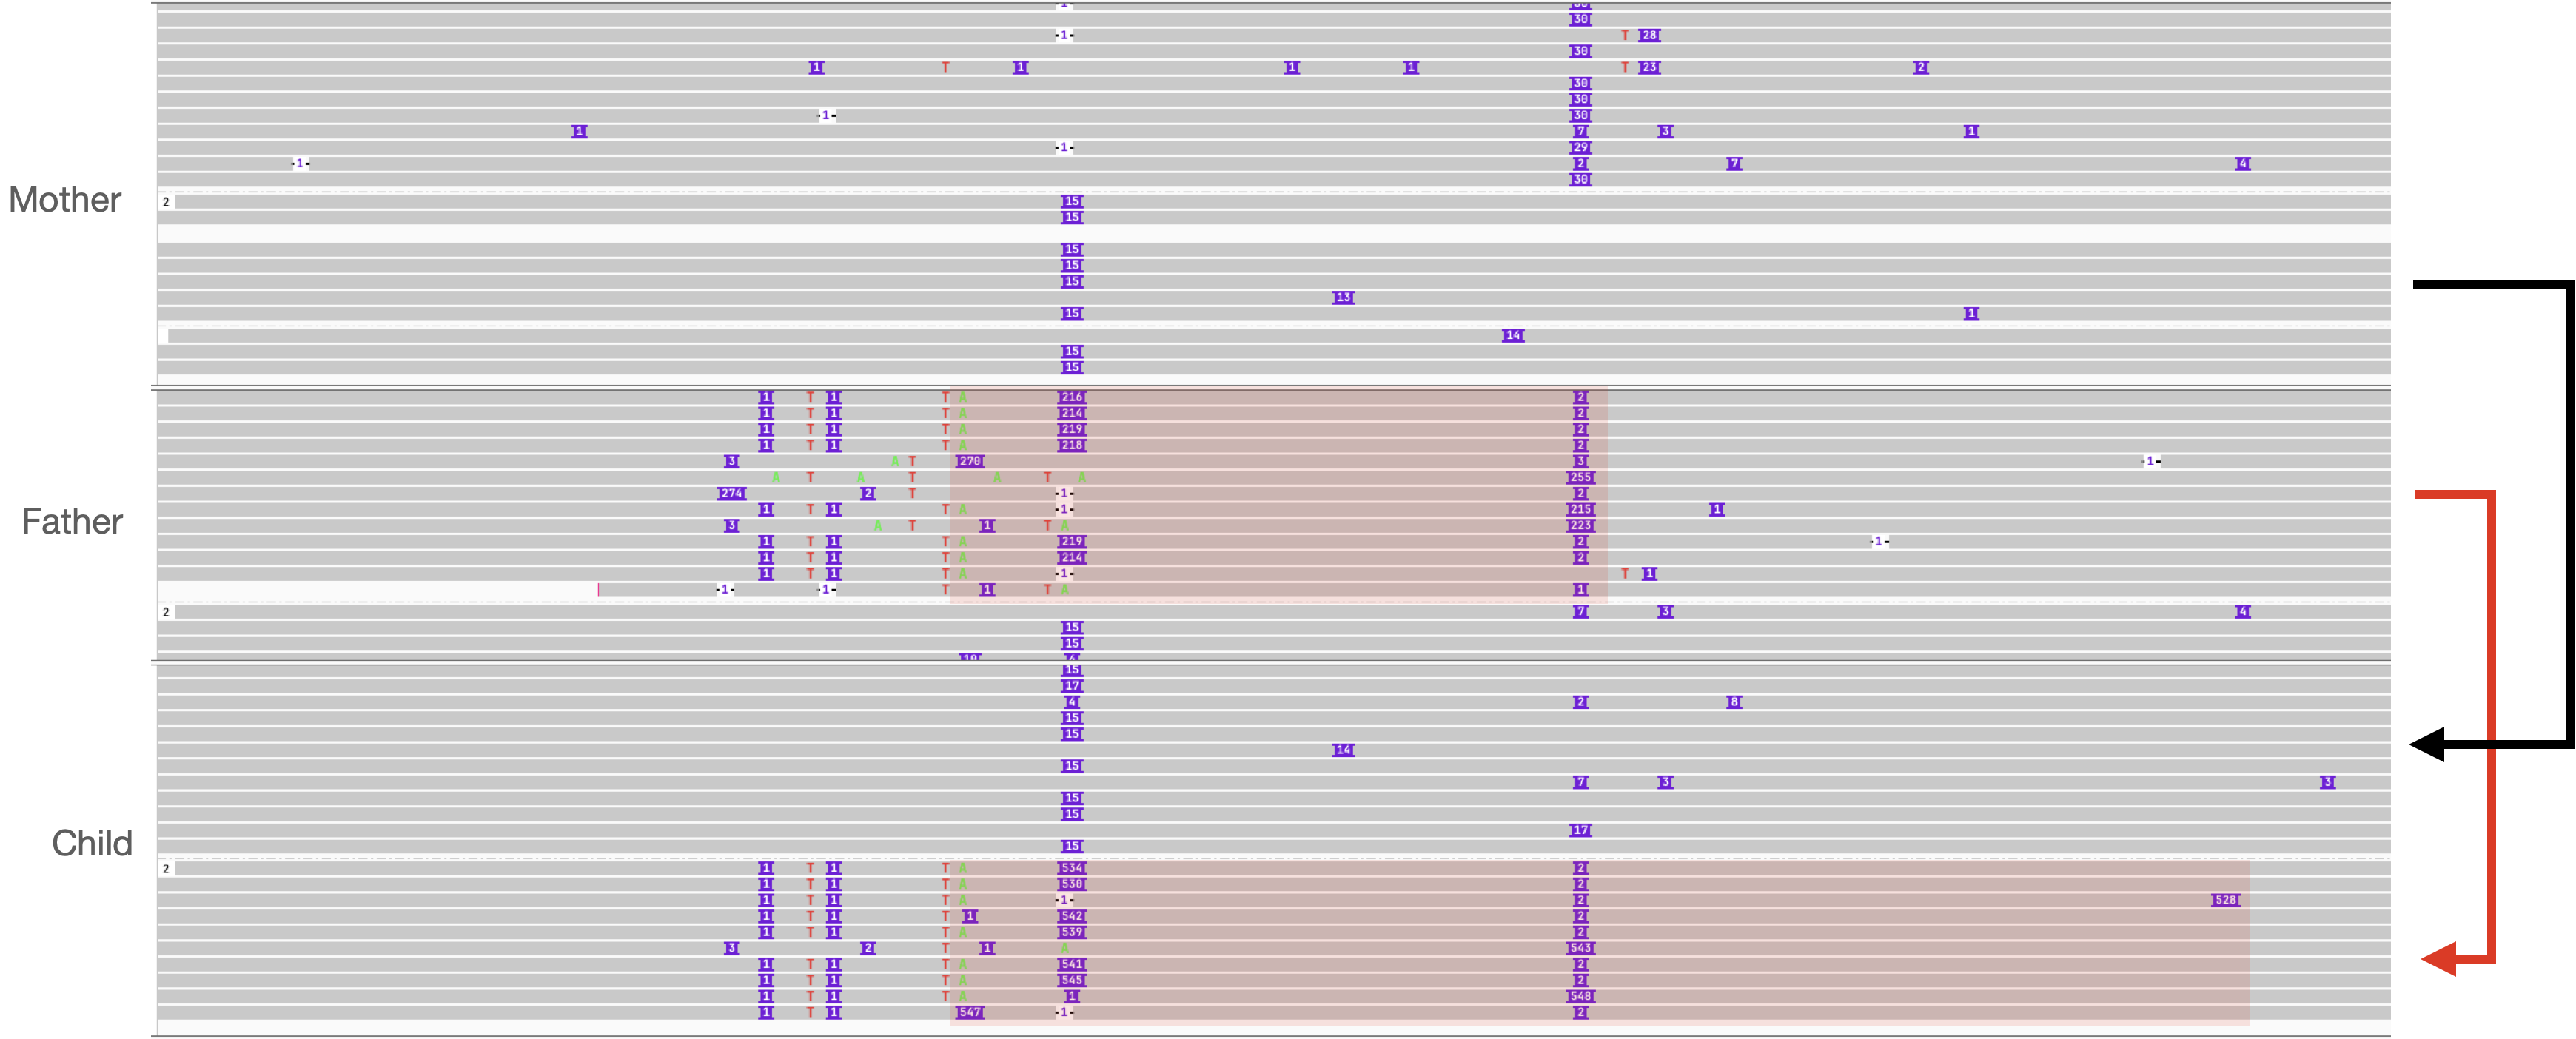

An example of a small event:
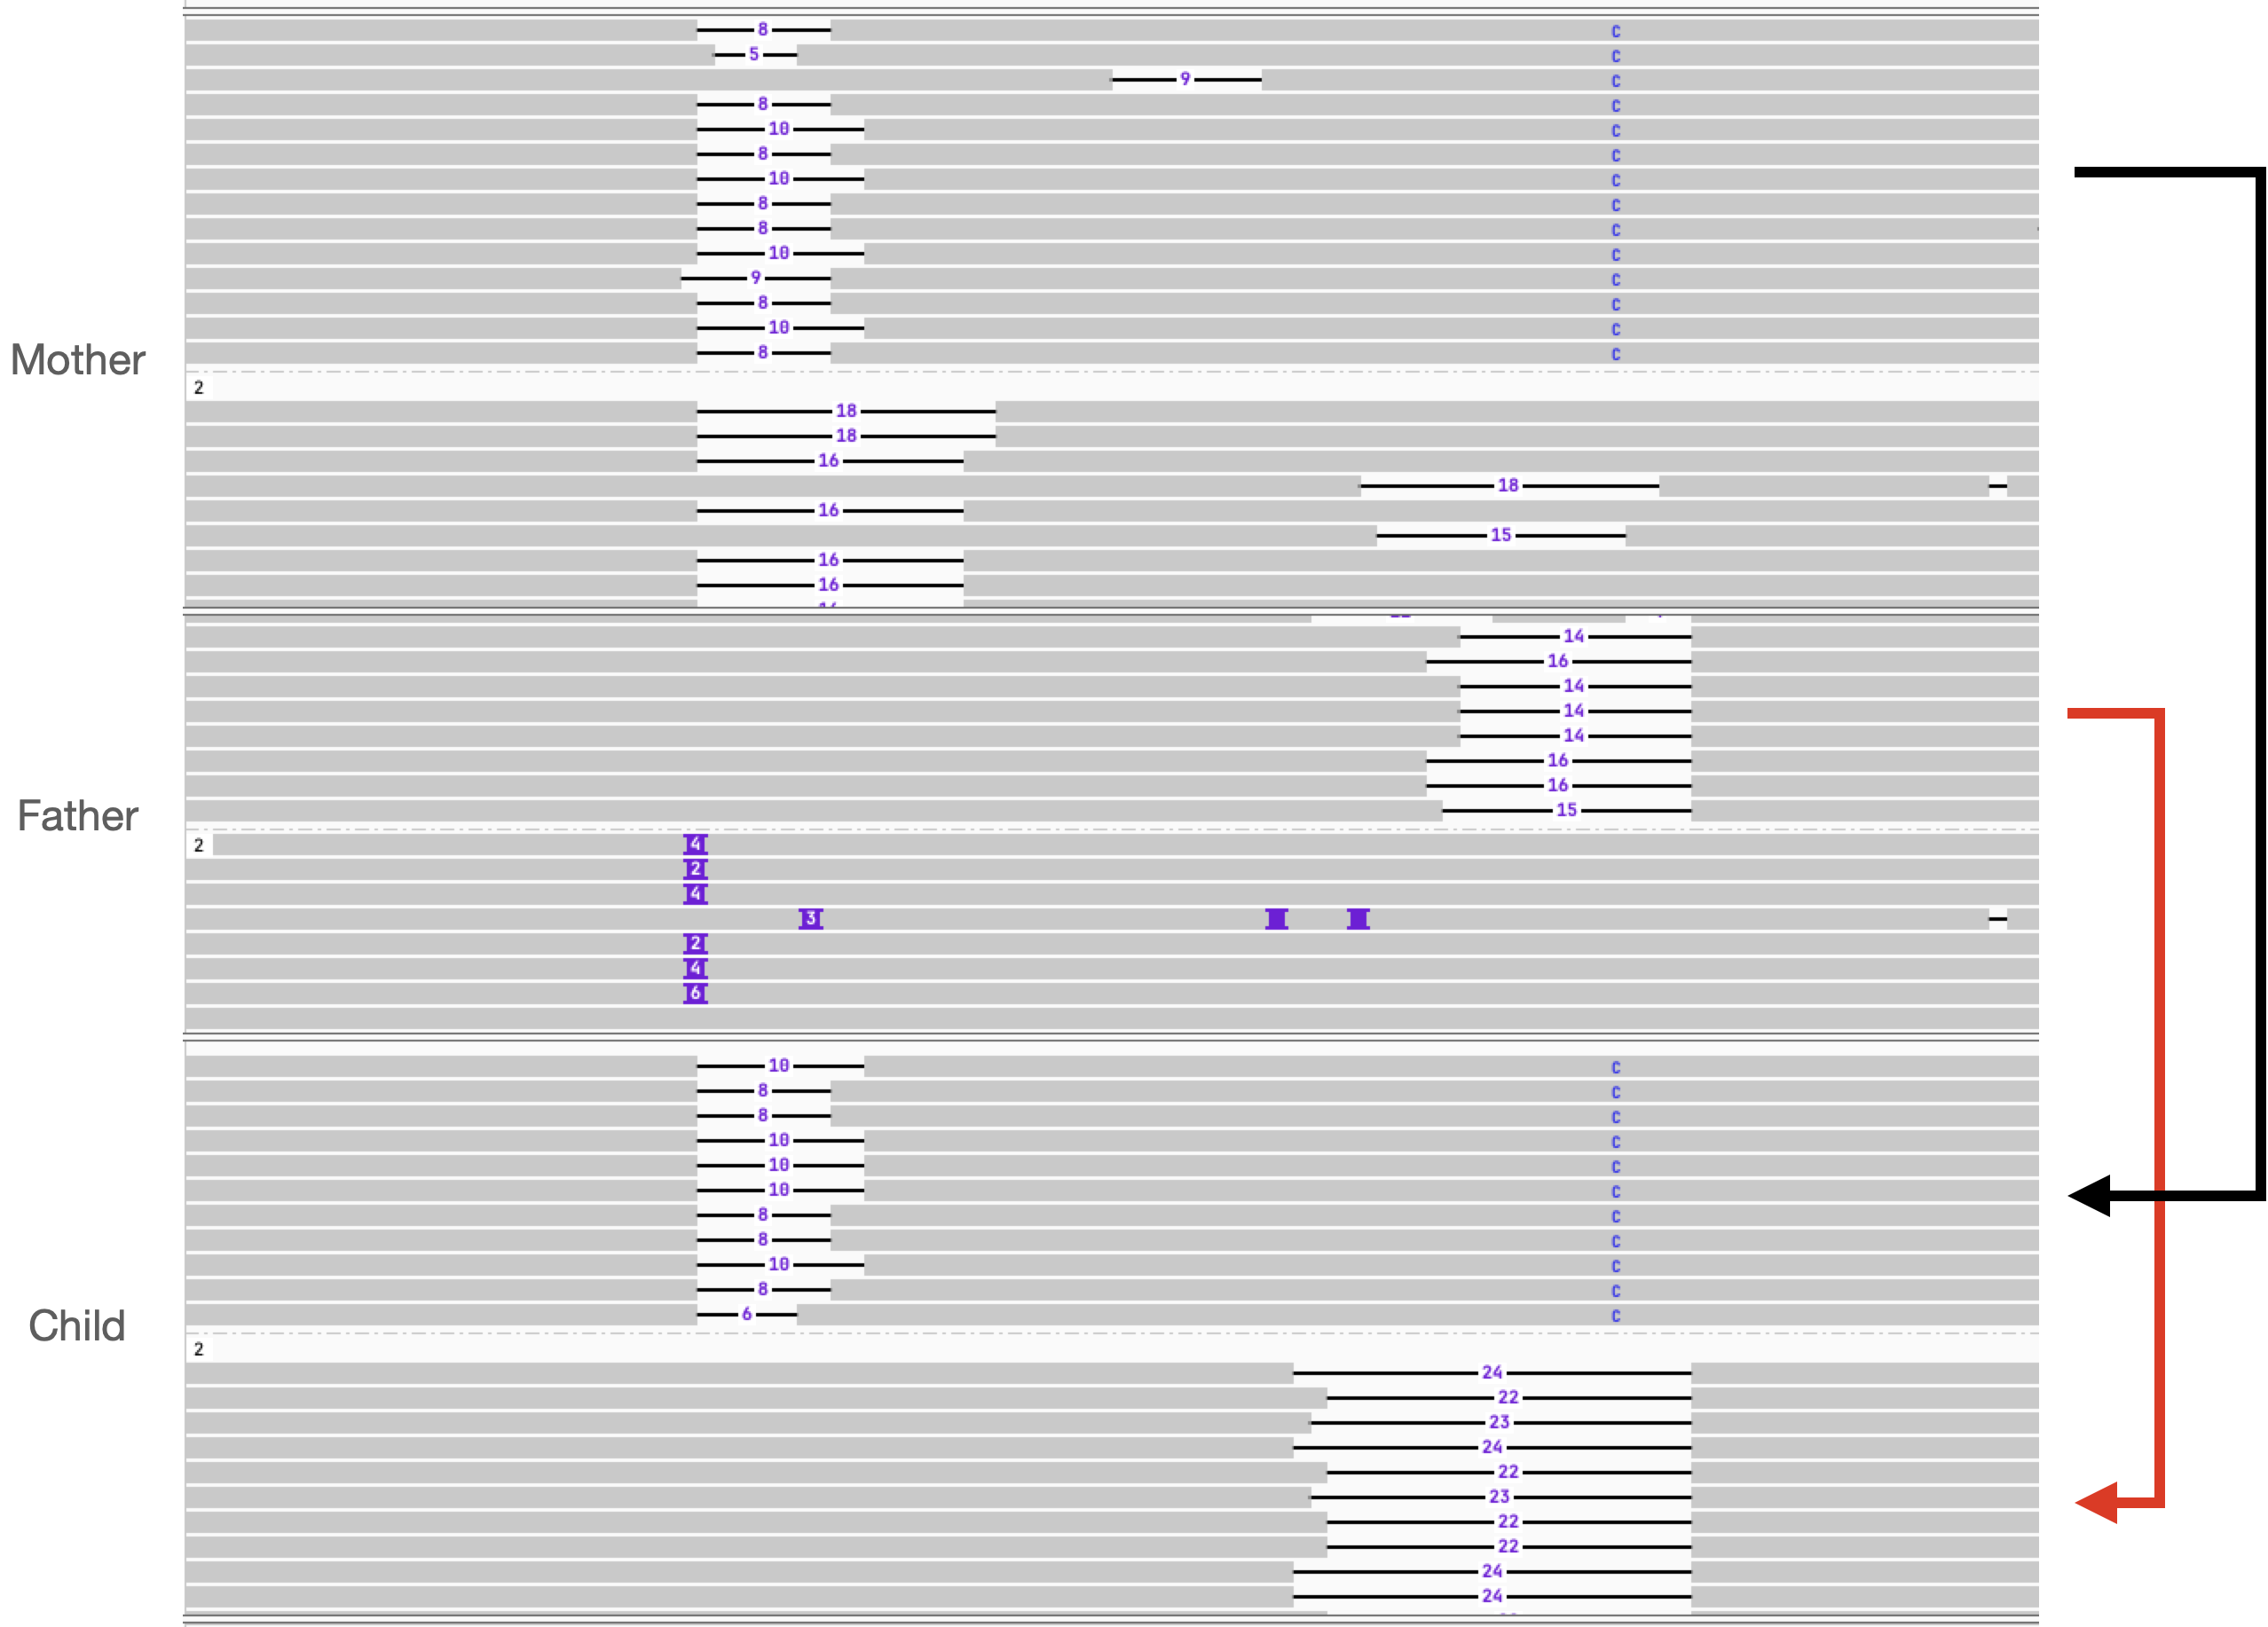

In [69]:
def filter_df(df):
    df_filt = df[
        (df['denovo_coverage'] >= 5) &
        (df['allele_ratio'] >= 0.7) &
        (df['child_ratio'].between(0.3, 0.7)) &
        (df['mother_dropout_prob'] < 0.005) &
        (df['father_dropout_prob'] < 0.005) &
        (df['mother_dropout'] == "N") & 
        (df['father_dropout'] == "N") &
        (df['mean_diff_mother'] > 7) & 
        (df['mean_diff_father'] > 7)          
    ].copy()        
    df_filt = df_filt.sort_values(by=["min_mean_diff"], ascending=False)
    return df_filt
    
df_filt = filter_df(df)